# BARTs Simulated Tubes Phantom

This tutorial uses the BART command-line inteface (CLI) (http://mrirecon.github.io/bart/) and presents how to use BART for creating simulated

* **Cartesian** phantoms in **image space**
* **non-Cartesian** phantoms in **k-space**

as well as analysing created parameter maps efficienty.

First, we need to define some helper functions to visualize our data arrays in the upcoming examples.

In [1]:
# Check and print BART version
echo "BART version"
bart version


# BASH function to write BART file to png and display it
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
}
export -f imshow


# BASH function to visualize timesteps of BART cfl files
function show_timesteps () {

    time_dimension=5

    # Read passed data
    data=$1
    shift
    pos=("$@")

    # Slice desired timesteps from array
    ind=0
    for t in "${pos[@]}"
    do
       bart slice $time_dimension $t $data _slice$ind
       ind=$((ind+1))
    done

    # Join desired timesteps and plot them beside each other
    bart join 6 `seq -f "_slice%g" 0 $((ind-1))` _slices
    bart reshape $(bart bitmask 1 6) $((DIM*ind)) 1 {_,}slices # only works if dim is set at execution time!
    imshow slices
}
export -f show_timesteps

BART version
v0.7.00


### Image Space Phantom

![title](figures/component_time.svg)
**Figure 1**

The TUBES phantom in BART consists of **geometric compontents** as illustrated in Figure 1, which can be multiplied with individual **signal compontents**. By summing over the component dimension the phantom is created.

This approach assumes homogeneous signals for each component, but allows for a very efficient phantom creation. No redundant simulations (as in the pixelwise case) need to be performed.

Additionally, by choosing the geometric components to live in the Fourier domain k-space based phantoms can be created easily. If the TUBES phantom in BART is created in k-space, the analytical expressions for ellipses are exploited to create the geometrical components. Through the linearity of the Fourier transformation a simple sum over all components is enough to create a final signal.

To start this tutorial we need to define some basic characteristics of the BART tubes phantom.

In [2]:
# Number of samples = Number of pixels
DIM=192

# ! the TUBES phantom in BART consists per default of 11 tubes !
GEOM_COMP=11

First, we have a look at the `phantom` command.

In [3]:
# print the help page of the phantom tool
bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-G ...] [-T ...] [-N d] [-B ...] [-x d] [-g d] [-3] [-b] [-r d] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S nc      	Output nc sensitivities
-k		k-space
-t file      	trajectory
-G		geometric object phantom
-T		tubes phantom
-N num      	Random tubes phantom and number
-B		BART logo
-x n      	dimensions in y and z
-g n=1,2      	select geometry for object phantom
-3		3D
-b		basis functions for geometry
-r seed      	random seed initialization
-h		help


The important flag is `-b`. It splits the output of the tubes phantom (specified by `-T`) into its basic geometrical components.

Now, we will create a first phantom and have a look at its dimensions.

In [4]:
bart phantom -x$DIM -T -b comp_geom

cat comp_geom.hdr

# Dimensions
192 192 1 1 1 1 11 1 1 1 1 1 1 1 1 1 
# Command
phantom -x192 -T -b comp_geom 
# Files
 >comp_geom
# Creator
BART v0.7.00


We can see the 11 basis functions in the coefficient dimension (6th). Next we flatten the coefficient dimension and plot it.

Flattend geometric components of tubes phantom


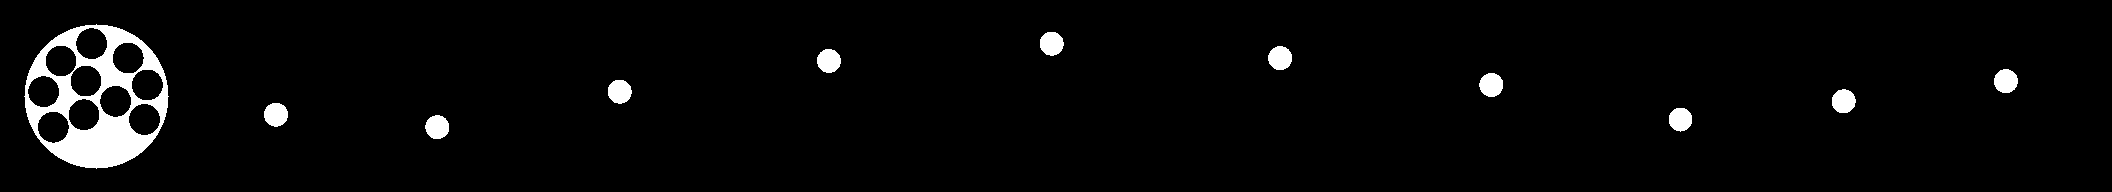

In [5]:
bart reshape $(bart bitmask 1 6) $((DIM*GEOM_COMP)) 1 comp_geom{,_flat}

echo "Flattend geometric components of tubes phantom"
imshow comp_geom_flat

This nicely presents the components of the BART tubes phantom.

In the next step, we create some signal components following an analytical Look-Locker signal model. This can be done with the `signal` tool in BART. 

In [6]:
bart signal -h

Usage: signal [-F ...] [-B ...] [-T ...] [-M ...] [-G ...] [--fat] [-I] [-s] [-0 ...] [-1 ...] [-2 ...] [-3 ...] [-r f] [-e f] [-f f] [-t f] [-n d] [-b d] <basis-functions>

Analytical simulation tool.

-F		FLASH
-B		bSSFP
-T		TSE
-M		MOLLI
-G		MGRE
--fat		Simulate additional fat component.
-I		inversion recovery
-s		inversion recovery starting from steady state
-0 min:max:N      	range of off-resonance frequency (Hz)
-1 min:max:N      	range of T1s (s)
-2 min:max:N      	range of T2s (s)
-3 min:max:N      	range of Mss
-r TR      	repetition time
-e TE      	echo time
-f FA      	flip ange
-t T1 relax      	T1 relax period (second) for MOLLI
-n n      	number of measurements
-b heart beats      	number of heart beats for MOLLI
-h		help


This tool provides various analytical signal evolutions. As mentioned we focus on an inversion recovery FLASH model using the flags `-F` and `-I`.

Additionally, we specify the repetition time $T_R$ with `-r` and the number of repetitions with `-n`.
T$_1$ and T$_2$ follow with `-1 min:max:N1` and `-2 min:max:N2`. $N_{1,2}$ provides the information of how many spin evolutions for the parameter combinations distributed equally between $min$ and $max$ should be simulated.

In [7]:
TR=0.0034
REP=400
T1=3 #[s]
T2=1 #[s]

NUM_SIMULATIONS=1

bart signal -F -I -r$TR -n$REP -1 $T1:$T1:$NUM_SIMULATIONS -2 $T2:$T2:$NUM_SIMULATIONS comp_water

cat comp_water.hdr

# Dimensions
1 1 1 1 1 400 1 1 1 1 1 1 1 1 1 1 
# Command
signal -F -I -r0.0034 -n400 -1 3:3:1 -2 1:1:1 comp_water 
# Files
 >comp_water
# Creator
BART v0.7.00


The command above creates the signal evolution of one voxel of water at 3 T for 400 repetitions of $T_R$. 
Now, let us create other relaxation times for the tubes.

For $T_1$ we create three combinations between 0.5 s and 2 s and for $T_2$ we want to have three combinations between 0.005 s and 0.2 s. Because all combinations of this parameters are simulated, we end up with nine different signal evolutions.

In [8]:
bart signal -F -I -r$TR -n$REP -1 0.5:2:3 -2 0.005:0.2:3 _comp_tubes

cat _comp_tubes.hdr

# Dimensions
1 1 1 1 1 400 3 3 1 1 1 1 1 1 1 1 
# Command
signal -F -I -r0.0034 -n400 -1 0.5:2:3 -2 0.005:0.2:3 _comp_tubes 
# Files
 >_comp_tubes
# Creator
BART v0.7.00


The nine evolutions are stored in two different dimensions (6th: coeff, 7th: coeff2). Because the first coefficent dimension is used for the geometry, we need to concentrate the signal basis in the second coefficent dimension (7th).


In [9]:
bart reshape $(bart bitmask 6 7) 9 1 {_,}comp_tubes

cat comp_tubes.hdr

# Dimensions
1 1 1 1 1 400 9 1 1 1 1 1 1 1 1 1 
# Command
reshape 192 9 1 _comp_tubes comp_tubes 
# Files
 >comp_tubes <_comp_tubes
# Creator
BART v0.7.00


In total the tubes phantom consists of 11 elements. Therefore, we need to multiply it with 11 signal components. Let us stack them together.

In [10]:
# We want to stack [water, tubes, water]. Therefore, the last tube of the geometry contains also water.
bart join 6 comp{_water,_tubes,_water,_simu}

To create the final simulation, we just have to multipy the geoemtric and the simulated signal components and sum over the component dimension as illustrated in Figure 1.

In [11]:
bart fmac -s $(bart bitmask 6) comp_{geom,simu} phantom

cat phantom.hdr

# Dimensions
192 192 1 1 1 400 1 1 1 1 1 1 1 1 1 1 
# Command
fmac -s 64 comp_geom comp_simu phantom 
# Files
 >phantom <comp_simu <comp_geom
# Creator
BART v0.7.00


For visualization we slice some timesteps from the created phantom, combine them in one array, flatten and visualize them.

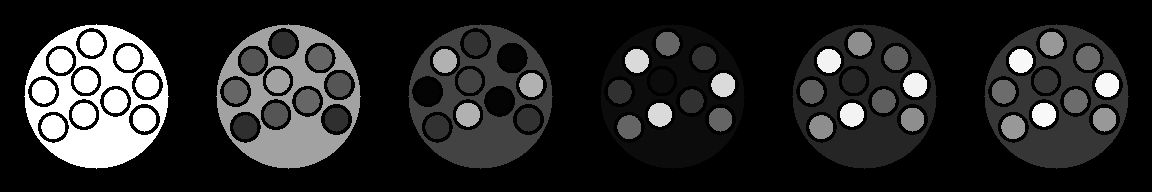

In [12]:
t=( 0, 100, 150, 200, 300, 399 )

show_timesteps phantom "${t[@]}"

### K-Space Phantom

For building a k-space based Cartesian phantom only a `-k` flag needs to be added to the previously shown `phantom` BART CLI command.
Afterwards the analytical Fourier representation for ellipses is used for creating the individual geometric components. By exploiting the Fourier transforms linearity, the full geometry is a linear compination of all components again.

Because the creation of a Cartesian k-space phantom does not differ more from the previously shown pixel domain one than adding a `-k` flag, here we present an example of how to create arbitrary **non-Cartesian k-space phantoms**.

Through the geometric and signal component design presented in Figure 1, we only have to adjust the creation of the geometrical components. The simulated signals stay the same.

To create a geometrical non-Cartesian k-space basis we first create the desired trajectory using the `traj` command. We choose a radial trajectory with 2-fold oversampling here.

In [19]:
SAMPLES=96
SPOKES=95

# Create trajectory
bart traj -x $((2*SAMPLES)) -y $SPOKES -r _traj

# Scale trajectory for 2-fold oversampling
bart scale 0.5 {_,}traj

The geometric components are estimated using the `phantom` tool. The `-k` flag creates k-space based phantoms and the `-t <traj>` flag allows to pass the trajectory information.

In [20]:
# Create phantom based on trajectory
bart phantom -T -b -k -t traj comp_geom_ksp

To have a look at the created geometrical basis we apply an inverse non-uniform Fourier transform to its spatial dimensions and reshape the coefficient dimension to plot all beside each other.

Done.
Flattend geometric components of tubes phantom transformed from k-space to image domain


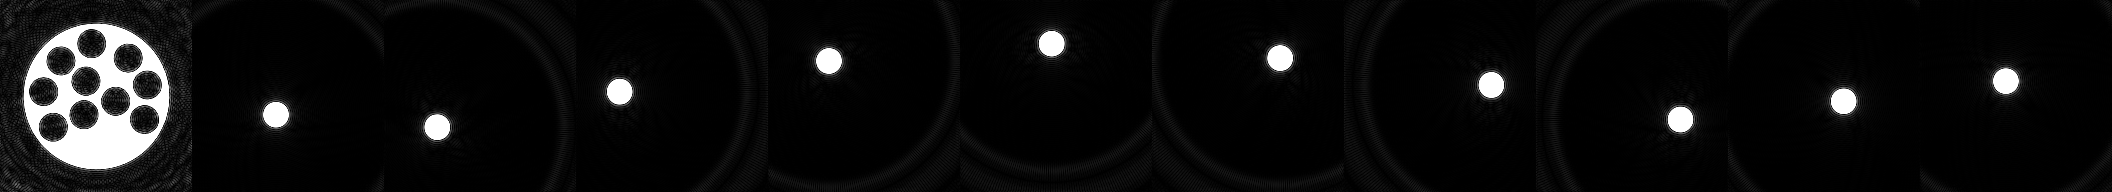

In [21]:
# Transform the non-Cartesian k-space samples to image domain
bart nufft -i -d $DIM:$DIM:1 traj comp_geom_{ksp,img}

bart reshape $(bart bitmask 1 6) $((DIM*GEOM_COMP)) 1 comp_geom_img{,_flat}

echo "Flattend geometric components of tubes phantom transformed from k-space to image domain"
imshow comp_geom_img_flat

The phantom creation afterwards becomes again a simple multiplication of the geometric and signal components with a summing over the component dimension. Here, we reuse the signals, which were simulated in the pixel-domain phantom example.

In [22]:
# Reuse the simulated signal components
bart fmac -s $(bart bitmask 6) comp_geom_ksp comp_simu phantom_ksp

Instead of multiplying the signal components with the k-space Fourier representations, we can also apply them to their transformation to image space. This allows us to visualize some timesteps of the phantom in image domain.

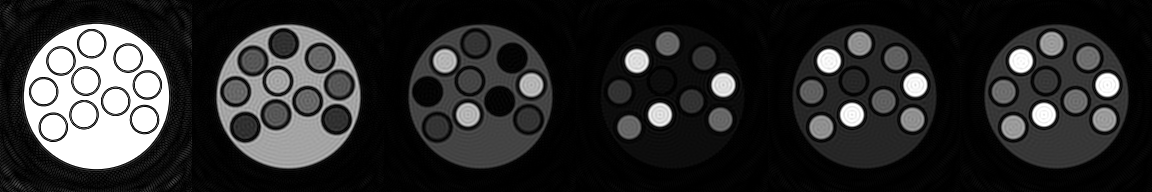

In [23]:
# Multiply signals with Fourier transformed kspace geometries
bart fmac -s $(bart bitmask 6) comp_geom_img comp_simu phantom_img

t=( 0, 100, 150, 200, 300, 399 )

show_timesteps phantom_img "${t[@]}"

To visualize the effect of frequency domain simulation we can compare the phantom simulations of the pixel-domain and k-space domain simulation at the same timestep.

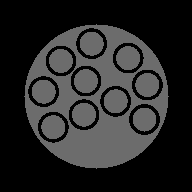

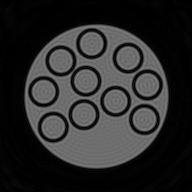

In [24]:
TIME_STEP=0

# Slice a timesteps from pixel-domain and Fourier transformed k-space phantom out
bart slice 5 $TIME_STEP phantom{,0}
imshow phantom0

bart slice 5 $TIME_STEP phantom_img{,0}
imshow phantom_img0

The ringing artifacts following from the multiplication of the objects frequency representation with a box function through sampling is good to observe.

### Tube Analysis of Parameter Map

After creation of numerical phantom with temporal signal evolutions, the BART TUBES phantom makes it handy to analyse resulting quantitiative parameter maps. To demonstrate this we start with creating an artifical parameter map.

The `index` tool creates a vector with numbers from 0 to 10, which is multiplied with the geometry basis functions from the `phantom` tool. Afterwards, the component dimension (6th) is summed up and an artifical parameter map is created with each geometry component storing its positional value as integer.

Artificial parameter map


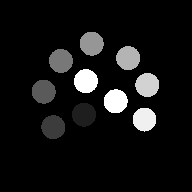

In [25]:
# Create vector with integers from 0 to 10
bart index 6 11 val

# create gemetric components in image domain
bart phantom -x$DIM -T -b coeff

# multiplication and summing over the component dimension produces the parameter map
bart fmac -s $(bart bitmask 6) coeff val maps

echo "Artificial parameter map"
imshow maps

By exploiting the splitting of the geometry from the signal, the extraction of the tubes parameters reduces to a simple multiplication of the parameter map with the phantoms basis components. The result stores the segmented tubes separated in the basis coefficient dimension.

In [26]:
bart phantom -x$DIM -T -b mask

bart fmac maps mask analysis

By slicing out one map of the segmented result, we can analyse the tube by estimating the maximum value of the map.

Maximum of 4 geometric component: +4.000000e+00+0.000000e+00i


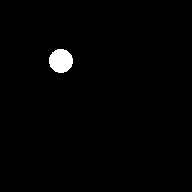

In [28]:
COMPONENT=4

bart slice 6 $COMPONENT analysis tube

# Estimate maximum of extracted tube by maximum-intensity projection over all(!) dimensions
bart mip 65535 tube max
echo "Maximum of $COMPONENT geometric component: $(bart show max)"

imshow tube

We can see, that the value is equal the position of the tube in the basis coefficient dimension. Therefore, we segmented the tube correctly.

In [ ]:
# Clean up
rm *.cfl *.hdr *.png